Exploratory Data Analysis: Creating the perfect song

After looking at all the audio features of each track on the Spotify API, I decided to analyze all these components across a dataset containing over 1.2 million Spotify songs to see if I can find out what makes the perfect song. I can then use the functions I wrote earlier to get the info of the Top 50 Global Spotify tracks from today and see how the two compare.

In [230]:
# Environment variables
from dotenv import load_dotenv
import os
import spotipy
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()

client_id = os.getenv("SPOTIPY_CLIENT_ID")
client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")
auth = SpotifyClientCredentials(client_id, client_secret)
spotify = spotipy.Spotify(auth = auth)

In [231]:
# Make sure CSV file is in base environment, read CSV of global top 50 songs
topSongsDf = pd.read_csv("globalTop50.csv")
topSongsDf.head()

,Unnamed: 0,Name,Track ID,Album,Artist,Release Date,Duration,Explicit?,Popularity,Danceability,Energy,Acousticness,Key,Tempo
0,0,Paint The Town Red,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,Doja Cat,2023-08-04,231750,True,99,0.868,0.538,0.26900,5,99.968
1,1,Seven (feat. Latto) (Explicit Ver.),7x9aauaA9cu6tyfpHnqDLo,Seven (feat. Latto),Jung Kook,2023-07-14,184400,True,99,0.802,0.832,0.31100,11,124.997
2,2,vampire,1kuGVB7EU95pJObxwvfwKS,GUTS,Olivia Rodrigo,2023-09-08,219724,True,75,0.511,0.532,0.17700,5,138.005
3,3,bad idea right?,3IX0yuEVvDbnqUwMBB3ouC,GUTS,Olivia Rodrigo,2023-09-08,184783,True,77,0.627,0.879,0.00193,9,129.979
4,4,all-american bitch,34sOdxWu9FljH84UXdRwu1,GUTS,Olivia Rodrigo,2023-09-08,165833,True,80,0.430,0.692,0.25400,6,156.261


In [232]:
# Read CSV of 600,000 songs
spotifyInitialDf = pd.read_csv("tracks.csv")
spotifyInitialDf = spotifyInitialDf.drop(spotifyInitialDf[spotifyInitialDf['popularity'] == 0].index)
spotifyInitialDf.head()
print(len(spotifyInitialDf.index))

541982


In [233]:
# Filter out the most popular songs; we want to analyze the most popular songs over the years to see what features and qualities they have
# We want to narrow the dataset to around 5000-10000 songs to make it easier to work with; let's see what we get
popularSpotifyDf = spotifyInitialDf[spotifyInitialDf['popularity'] > 70]
print(f"Initial song count: {len(spotifyInitialDf.index)}")
print(f"Popular song count (popularity > 80): {len(popularSpotifyDf.index)}")
# Let's also get the least popular songs so we can compare them to see if there is a big difference
unpopularSpotifyDf = spotifyInitialDf[(spotifyInitialDf['popularity'] < 10) & (spotifyInitialDf['popularity'] > 0)]
print(f"Unpopular song count (popularity < 10 and > 0): {len(unpopularSpotifyDf.index)}")
popularSpotifyDf.head()

Initial song count: 541982
Popular song count (popularity > 80): 6213
Unpopular song count (popularity < 10 and > 0): 76918


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
30498,78MI7mu1LV1k4IA2HzKmHe,Dream A Little Dream Of Me - Single Version,74,185160,0,"['Ella Fitzgerald', 'Louis Armstrong']","['5V0MlUE1Bft0mbLlND7FJz', '19eLuQmk9aCobbVDHc...",1957-01-01,0.443,0.104,0,-17.042,1,0.1010,0.913,0.000000,0.1910,0.394,76.497,4
31498,6VTbbVjKOC2qWagIDbkJrC,My Baby Just Cares for Me - 2013 Remastered Ve...,71,215747,0,['Nina Simone'],['7G1GBhoKtEPnP86X2PvEYO'],1958-06-24,0.746,0.243,4,-15.134,0,0.1230,0.829,0.000001,0.0905,0.425,118.578,4
31499,4gphxUgq0JSFv2BCLhNDiE,Jailhouse Rock,71,146480,0,['Elvis Presley'],['43ZHCT0cAZBISjO8DG9PnE'],1958-03-21,0.647,0.582,10,-9.538,0,0.0755,0.410,0.000002,0.0715,0.915,167.396,4
32498,2QfiRTz5Yc8DdShCxG1tB2,Johnny B. Goode,77,161560,0,['Chuck Berry'],['293zczrfYafIItmnmM3coR'],1959-07-01,0.534,0.803,10,-9.129,1,0.0743,0.741,0.000061,0.3070,0.969,167.983,4
33498,4Hhv2vrOTy89HFRcjU3QOx,At Last,77,179693,0,['Etta James'],['0iOVhN3tnSvgDbcg25JoJb'],1960,0.274,0.348,5,-8.631,1,0.0293,0.547,0.013300,0.3340,0.328,87.430,3


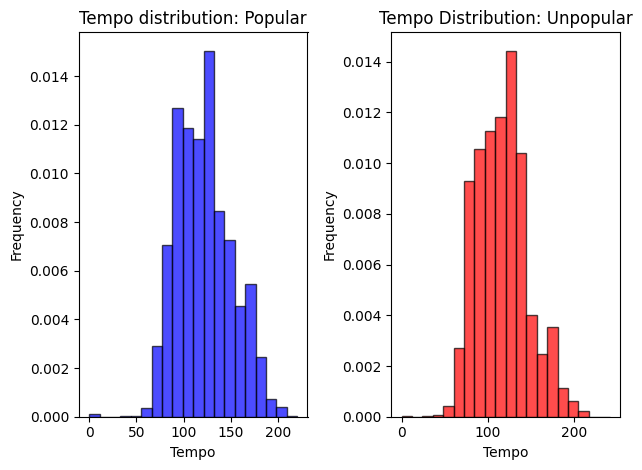

121.66352969579913
116.50743004238284


In [234]:
# Analyze tempo between unpopular and popular songs
popularSongCount = len(popularSpotifyDf.index)
unpopularSongCount = len(unpopularSpotifyDf.index)
popularTempoData = popularSpotifyDf["tempo"]
unpopularTempoData = unpopularSpotifyDf["tempo"]
# Plot histograms between the two
plt.subplot(1, 2, 1)
plt.hist(popularTempoData, bins = 20, color = 'blue', edgecolor = 'black', alpha = 0.7, density = True)
plt.xlabel('Tempo')
plt.ylabel('Frequency')
plt.title("Tempo distribution: Popular")
plt.subplot(1, 2, 2)
plt.hist(unpopularTempoData, bins = 20, color = 'red', edgecolor = 'black', alpha = 0.7, density = True)
plt.title('Tempo Distribution: Unpopular')
plt.xlabel('Tempo')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# Print averages
print(popularTempoData.mean())
print(unpopularTempoData.mean())

In [235]:
# It looks like the tempo between popular and unpopular songs did not vary by much. Let's see what variables have the most correlation with popularity:
spotifyNumDf = spotifyInitialDf[['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 
                                 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
spotifyNumDf.corr().abs()[['popularity']]
# Explicit, danceability (maybe?), energy, loudness, acousticness, instrumentalness

,popularity
popularity,1.000000
duration_ms,0.030538
explicit,0.216655
danceability,0.183819
energy,0.248731
key,0.015741
loudness,0.302657
mode,0.028097
speechiness,0.020892
acousticness,0.306289


In [237]:
# Explicit?
popularExplicitData = popularSpotifyDf['explicit']
explicitCount = (popularExplicitData == 1).sum()
nonexplicitCount = (popularExplicitData == 0).sum()
print(explicitCount)
print(nonexplicitCount)
# Looks like we want our song to be nonexplicit.

1809
4404


Text(0, 0.5, 'Frequency')

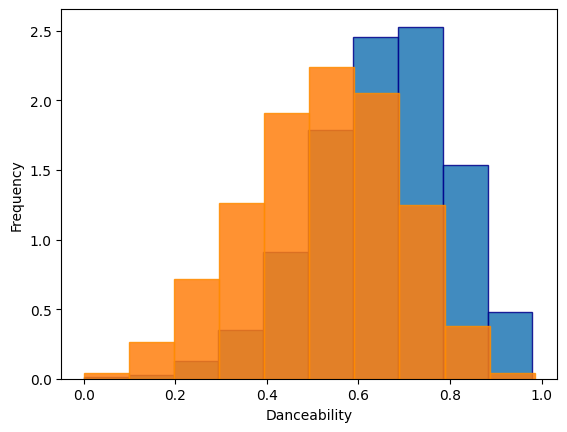

In [222]:
# Danceability
popularDanceability = popularSpotifyDf['danceability']
unpopularDanceability = unpopularSpotifyDf['danceability']
plt.hist(popularDanceability, alpha = 0.85, edgecolor = 'darkblue', density = True)
plt.hist(unpopularDanceability, alpha = 0.85, edgecolor = 'darkorange', density = True)
plt.xlabel('Danceability')
plt.ylabel('Frequency')
# We want a danceability of between 0.7 and 0.8

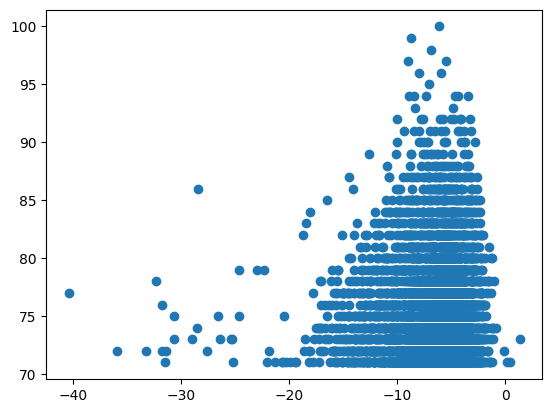

In [236]:
# Energy
